In [1]:
import torch
import pandas as pd

torch.__version__, torch.cuda.is_available()

('2.9.0+cu128', True)

In [2]:
import sys
import os
from pathlib import Path

project_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from cuda_benchmark import CUDABenchmark

In [3]:
%load_ext wurlitzer

import torch
from torch.utils.cpp_extension import load_inline

def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [4]:
cuda_src = cuda_begin + r'''
__global__ void vectorAddKernel(float *out, float *a, float *b, int n) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    if (i < n) {
        out[i] = a[i] + b[i];
    }
}

torch::Tensor vectorAdd(torch::Tensor a, torch::Tensor b) {
    CHECK_INPUT(a); CHECK_INPUT(b);
    int n = a.size(0);
    auto output = torch::empty(n, a.options());
    int threads = 256;
    vectorAddKernel<<<cdiv(n, threads), threads>>>(output.data_ptr<float>(), a.data_ptr<float>(), b.data_ptr<float>(), n);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}''' + r'''
__global__ void vectorAddImprovedKernel(const float* __restrict__ A,
                           const float* __restrict__ B,
                           float* __restrict__ C, int N) {
    // Grid-stride loop: start at this thread's index, then stride by total threads
    for (int i = blockIdx.x * blockDim.x + threadIdx.x;
         i < N;
         i += blockDim.x * gridDim.x) {
        C[i] = A[i] + B[i];
    }
}

torch::Tensor vectorAddImproved(torch::Tensor a, torch::Tensor b) {
    CHECK_INPUT(a); CHECK_INPUT(b);
    int n = a.size(0);
    auto output = torch::empty(n, a.options());
    int threads = (n < 128) ? 32 : 128;
    int blocks = cdiv(n, threads);
    if (blocks == 0) blocks = 1;
    vectorAddImprovedKernel<<<blocks, threads>>>(a.data_ptr<float>(), b.data_ptr<float>(), output.data_ptr<float>(), n);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

cpp_src = """
torch::Tensor vectorAdd(torch::Tensor a, torch::Tensor b);
torch::Tensor vectorAddImproved(torch::Tensor a, torch::Tensor b);
"""

funcs = ['vectorAdd', 'vectorAddImproved']

module = load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=True)

dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'vectorAdd',
 'vectorAddImproved']

In [14]:
# Usage example:
bench = CUDABenchmark(warmup_runs=3, benchmark_runs=10)

# Define test data
N = 100_000_000
a = torch.randn(N, device='cuda')
b = torch.randn(N, device='cuda')

# Define implementations
implementations = {
    'vectorAdd': lambda a, b: module.vectorAdd(a, b),
    'vectorAddImproved': lambda a, b: module.vectorAddImproved(a, b),
}

# Compare against PyTorch
results_df = bench.compare_implementations(
    implementations=implementations,
    test_data={'a': a, 'b': b},
    reference_func=lambda a, b: a + b,
    reference_name='PyTorch'
)

# Display results
print(results_df[['name', 'mean_ms', 'std_ms', 'speedup', 'correct']].to_string())


                name   mean_ms    std_ms   speedup correct
0            PyTorch  1.403794  0.008238  1.000000     NaN
1          vectorAdd  1.406171  0.004213  0.998310    True
2  vectorAddImproved  1.397836  0.004654  1.004262    True


In [15]:
torch.cuda.empty_cache()

In [16]:
# Test different tensor sizes
sizes = [10**6, 10**7, 10**8]
size_results = []

for size in sizes:
    torch.cuda.empty_cache()
    a = torch.randn(size, device='cuda')
    b = torch.randn(size, device='cuda')
    
    result = bench.compare_implementations(
        implementations=implementations,
        test_data={'a': a, 'b': b},
        reference_func=lambda a, b: a + b,
        reference_name='PyTorch'
    )
    result['size'] = size
    size_results.append(result)

# Combine and visualize
all_results = pd.concat(size_results)

In [17]:
def calculate_bandwidth(time_ms, size_bytes):
    """Calculate memory bandwidth in GB/s"""
    return (size_bytes / (1024**3)) / (time_ms / 1000)

# Add bandwidth to results
results_df['bandwidth_gbs'] = calculate_bandwidth(
    results_df['mean_ms'], 
    N * 4 * 3  # 3 tensors (a, b, output) * 4 bytes per float
)

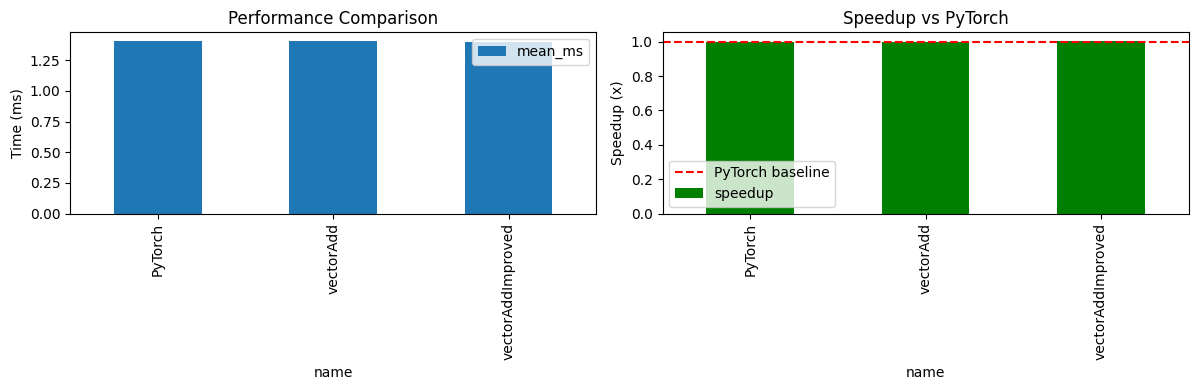

In [18]:
import matplotlib.pyplot as plt

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Time comparison
results_df.plot(x='name', y='mean_ms', kind='bar', ax=ax1, 
                yerr=results_df['std_ms'], capsize=4)
ax1.set_ylabel('Time (ms)')
ax1.set_title('Performance Comparison')

# Speedup comparison
results_df.plot(x='name', y='speedup', kind='bar', ax=ax2, color='green')
ax2.axhline(y=1.0, color='r', linestyle='--', label='PyTorch baseline')
ax2.set_ylabel('Speedup (x)')
ax2.set_title('Speedup vs PyTorch')
ax2.legend()

plt.tight_layout()
plt.show()

In [19]:
torch.cuda.empty_cache()